In [424]:
import pandas as pd
import numpy as np
import os, sys, glob
from pathlib import Path
from scipy.interpolate import interp2d
from emgineer import EmgDecomposition
import matplotlib.pyplot as plt

from statistics import median,variance,stdev
from scipy import stats
import math

from calc_fr import st2fr, label_fr

import pickle, json
from sklearn.metrics.pairwise import cosine_similarity

sys.path.append('../load_intan_rhd_format')

from load_filt_test import read_data, guolv

def filt_all_rhd(path):
    rhd = read_data(path)
    array_emg = rhd['amplifier_data']
    array_emg = array_emg[:, 2000:]
    array_emg_filt = guolv(array_emg).T
    return array_emg_filt

def rms(x, axis=None):
    return np.sqrt(np.mean(x**2, axis=axis))

# grid

In [764]:
def plot_sensor_grid(M, n_lim=None, figsize=(16.0, 10.0), cmap='viridis', interporate_rate=1):
    if n_lim is None:
        n_lim = M.shape[0]
    fig = plt.figure(figsize=figsize)
    for i in range(n_lim):
        _electrodes = M[i].reshape((8, 8))
        if interporate_rate != 1:
            _electrodes = interporate_grid(_electrodes, rate=interporate_rate)
        ax = fig.add_subplot(-(-n_lim//5), 5, i + 1)
        ax.pcolor(_electrodes, cmap=cmap)
        ax.tick_params(
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
            bottom=False,
            left=False,
            right=False,
            top=False)
        ax.set_title('MU ' + str(i + 1))

def interporate_grid(Z, rate=2):
    x = np.linspace(0, 7, 8)
    y = np.linspace(0, 7, 8)
    
    x2 = np.linspace(0, 7, int(8 * rate))
    y2 = np.linspace(0, 7, int(8 * rate))
    # X2, Y2 = np.meshgrid(x2, y2)

    f = interp2d(x, y, Z, kind='cubic')
    Z2 = f(x2, y2)
    return Z2

def min_max(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min + 1e-16)
    return result

In [421]:
df_filename_analysis = pd.read_csv('table_filename_analysis.csv', index_col=0, header=0)

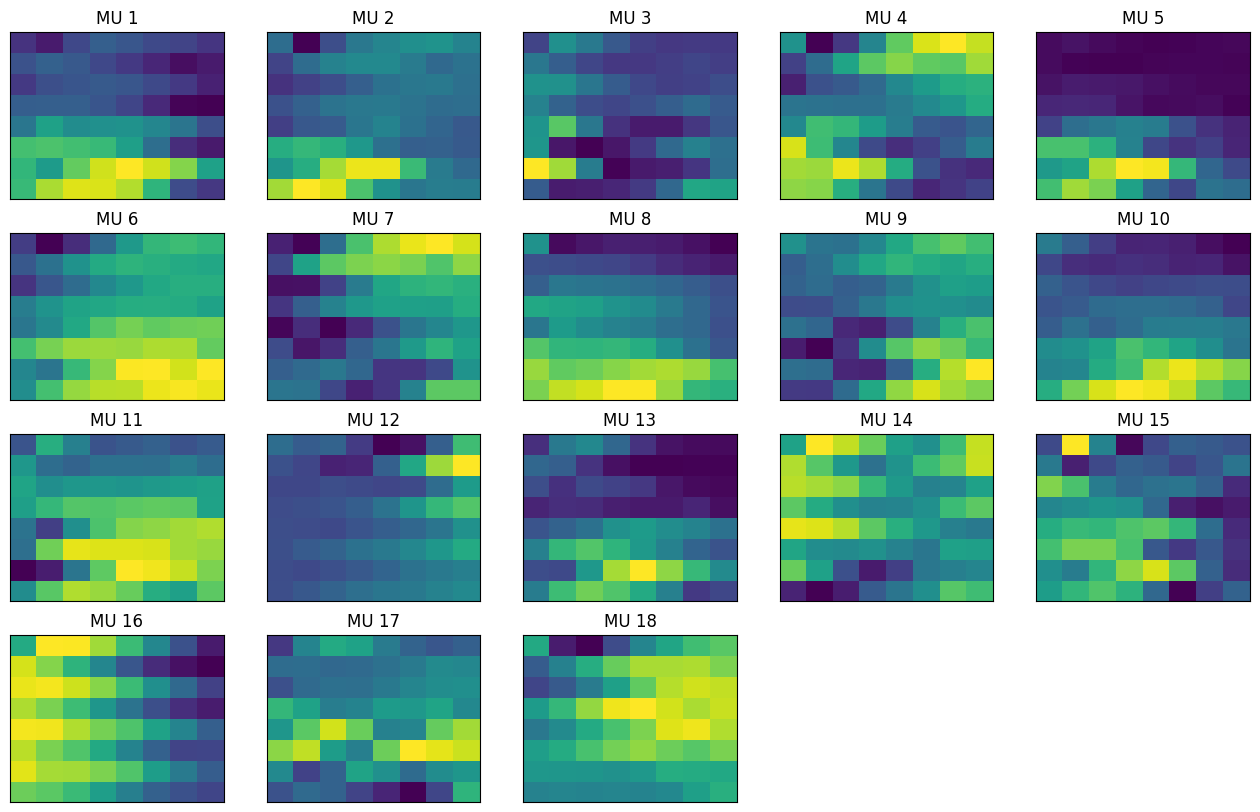

In [765]:
motion_name = 'imrl'
subject_name = 'tei'
filename = df_filename_analysis[subject_name][motion_name]

path_analysis = f'__cashe__/{subject_name}_{filename}_mu20'

with open(f'{path_analysis}/all_fastica.pickle', 'rb') as f:
    est_analysis = pickle.load(f)
with open(f'{path_analysis}/all_sil.json', 'rb') as f:
    json_analysis = json.load(f)

mixing_mat = est_analysis.mixing_.T
valid_mixing = json_analysis['valid_index_mu']


# extendした信号を足し合わせる, spike trainsを算出するとき負の値は二乗されて正になるので、square(absでもできるが強調のためsquare)
# mix_all = np.square(C).reshape((C.shape[0], -1, 64)).sum(axis=1)

mix_all = rms(mixing_mat.reshape((mixing_mat.shape[0], -1, 64)), axis=1)[valid_mixing, :]

plt.rcParams['figure.figsize'] = (8.0, 4.0)
plot_sensor_grid(mix_all, interporate_rate=1)

# mu から有意なものを選択

1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 0.0
9: 0.720940427923971
10: 0.013612672791475518
11: 0.31297179081347204
12: 0.4187950345340741
13: 0.3698596409466892
14: 0.6676036408644692
15: 0.4296893746458822
16: 0.5019894713856007
17: 0.4035425023854524
(-0.2900197143022863, 0.7416673091600612)


(0.0, 1.0)

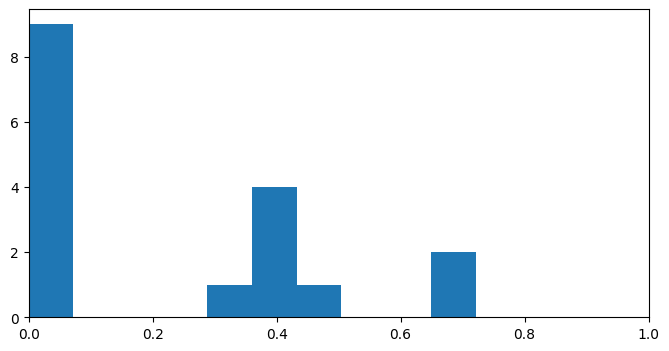

In [441]:
def confidence_interval(x, alpha=0.95):
    bottom, up = stats.norm.interval(alpha=alpha, loc=np.mean(x), scale=stdev(x))
    return bottom, up

motion_name = 'five'
subject_name = 'zhang'

meanfr = pd.read_csv(f'fr_mean/meanfr_{motion_name}_{subject_name}.csv', index_col=0, header=0).values

list_cos_sim = []
for j, m in enumerate(meanfr):
    cos_sim = cosine_similarity([[0,0,0,0,1], m])[0][1]
    list_cos_sim.append(cos_sim)
    print(f'{j+1}: {cos_sim}')

print(confidence_interval(list_cos_sim))

_ = plt.hist(list_cos_sim)
plt.xlim(0,1)

In [776]:
threshold = 0.8

dic_cos_sim = dict()

for subject_name in ['tei', 'li', 'nakashima', 'zhang']:
    print(subject_name)
    for motion_name in ['five', 'imrl']:
        dic_cos_sim[motion_name] = dict()
        meanfr = pd.read_csv(f'fr_mean/meanfr_{motion_name}_{subject_name}.csv', index_col=0, header=0).values
        if motion_name == 'five':
            unit_vecs = [[0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]]
        if motion_name == 'imrl':
            unit_vecs = [[1,1,1,1], [0,1,1,1], [0,0,1,1], [0,0,0,1]]
        for unit, finger_name in zip(unit_vecs, ['1', '2', '3', '4']):
            list_mu_cos_sim = []
            for j, m in enumerate(meanfr):
                cos_sim = cosine_similarity([unit, m])[0][1]
                list_mu_cos_sim.append(cos_sim)
            list_mu_finger = np.where(min_max(np.array(list_mu_cos_sim)) > threshold)[0].tolist()
            # list_mu_finger = np.where(np.array(list_mu_cos_sim) > threshold)[0].tolist()
            # if len(list_mu_finger) == 0:
            #     list_mu_finger = [np.argmax(list_mu_cos_sim)]
                
            dic_cos_sim[motion_name][finger_name] = dict()
            dic_cos_sim[motion_name][finger_name]['index of mu'] = [int(x) for x in  list_mu_finger]
            dic_cos_sim[motion_name][finger_name]['cos sim of mu'] = list_mu_cos_sim
            
            print([int(x) + 1 for x in  list_mu_finger])


    json_file = open(f'significance/{subject_name}.json', 'w')
    json.dump(dic_cos_sim, json_file, indent=4)
    json_file.close()

nakashima
[7, 9]
[5, 6]
[1, 2, 3, 4, 12]
[8, 10, 14]
[12, 13, 14, 15]
[3, 6, 10, 12, 13, 14, 15]
[1, 4, 7, 10]
[2, 5, 11]
zhang
[9, 14, 16]
[11, 12, 13, 15]
[1, 2, 3, 4, 5, 6, 10]
[9, 14]
[7, 8, 9, 12, 13, 14, 15, 16]
[8, 11, 12, 13, 14, 15, 16]
[5, 6, 8, 10, 11, 13]
[1, 2, 3, 4, 5]


# MUAP waveform表示・評価

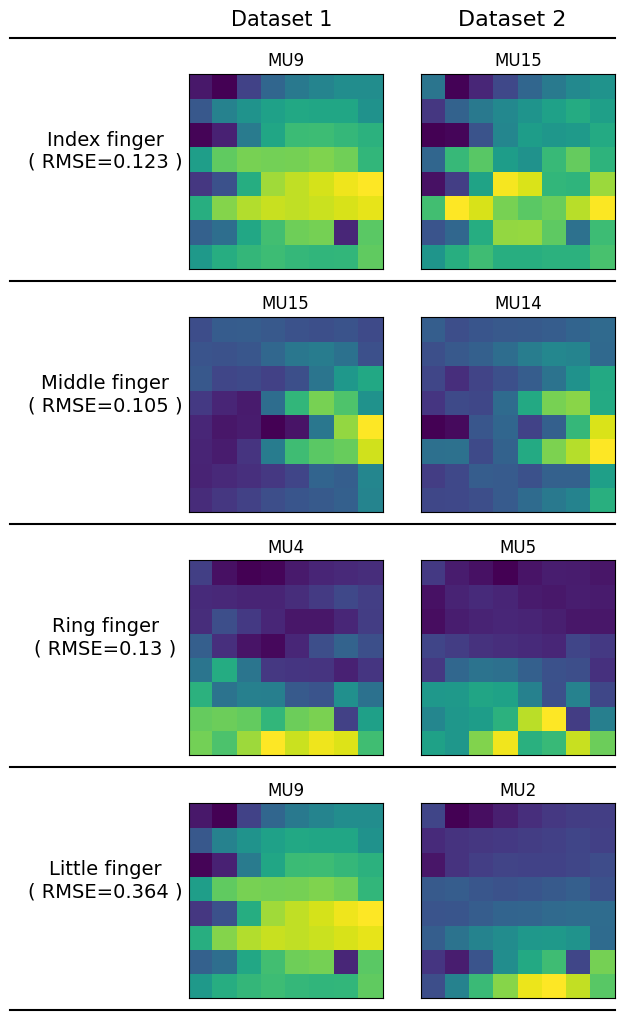

In [770]:
# cos sim のところはrms
import matplotlib.lines as lines

subject_name = 'zhang'

with open(f'significance/{subject_name}.json', 'rb') as f:
    dic_cos_sim = json.load(f)

fig = plt.figure(figsize=(5.5, 12))
for k, finger_name_ in enumerate([1,2,3,4]):
    finger_name = str(finger_name_)
    dict_grids = dict()
    for motion_name in ['five', 'imrl']:
        filename = df_filename_analysis[subject_name][motion_name]

        path_analysis = f'__cashe__/{subject_name}_{filename}_mu20'

        with open(f'{path_analysis}/all_fastica.pickle', 'rb') as f:
            est_analysis = pickle.load(f)
        with open(f'{path_analysis}/all_sil.json', 'rb') as f:
            json_analysis = json.load(f)

        mixing_mat = est_analysis.mixing_.T
        valid_mixing = json_analysis['valid_index_mu']

        mix_all = rms(mixing_mat.reshape((mixing_mat.shape[0], -1, 64)), axis=1)[valid_mixing, :]
        
        dict_grids[motion_name] = dict()
        dict_grids[motion_name]['grids'] = mix_all
        dict_grids[motion_name]['index_grids'] = dic_cos_sim[motion_name][finger_name]['index of mu']

    five_grids = dict_grids['five']['grids']
    imrl_grids = dict_grids['imrl']['grids']
    five_index_grids = dict_grids['five']['index_grids']
    imrl_index_grids = dict_grids['imrl']['index_grids']

    list_cos_sim_grids = []
    list_index_comb_grids = []
    for i_five in five_index_grids:
        for i_imrl in imrl_index_grids:
            #list_cos_sim_grids.append(cosine_similarity([five_grids[i_five], imrl_grids[i_imrl]])[0][1])
            list_cos_sim_grids.append(-rms(min_max(five_grids[i_five])-min_max(imrl_grids[i_imrl])))
            list_index_comb_grids.append([i_five, i_imrl])
    #print(np.argmax(list_cos_sim_grids), len(list_index_comb_grids))
    index_comb_max_cos_sim = list_index_comb_grids[np.argmax(list_cos_sim_grids)]
    five_selected = five_grids[index_comb_max_cos_sim[0]].reshape((8, 8))
    imrl_selected = imrl_grids[index_comb_max_cos_sim[1]].reshape((8, 8))
    
    # print(f'MU{index_comb_max_cos_sim[0] + 1}, MU{index_comb_max_cos_sim[1] + 1}: {np.max(list_cos_sim_grids)}')

    ax = fig.add_subplot(4, 2, k * 2 + 1)
    ax.pcolor(five_selected, cmap='viridis')
    ax.tick_params(
        labelbottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
        bottom=False,
        left=False,
        right=False,
        top=False)
    fingers = ['Index finger', 'Middle finger', 'Ring finger', 'Little finger']
    ax.set_ylabel(fingers[k] + f'\n( RMSE={round(-np.max(list_cos_sim_grids), 3)} )', rotation=0, labelpad=60, size=14)
    if k == 0:
        ax.text(1.75, 10 ,'Dataset 1', size=15)
    ax.set_title(f'MU{index_comb_max_cos_sim[0] + 1}')

    ax = fig.add_subplot(4, 2, k * 2 + 2)
    ax.pcolor(imrl_selected, cmap='viridis')
    ax.tick_params(
        labelbottom=False,
        labelleft=False,
        labelright=False,
        labeltop=False,
        bottom=False,
        left=False,
        right=False,
        top=False)
    if k == 0:
        ax.text(1.5, 10,'Dataset 2', size=16)
    ax.set_title(f'MU{index_comb_max_cos_sim[1] + 1}')



fig.subplots_adjust(hspace=0.25)
fig.add_artist(lines.Line2D([-0.2, 0.9], [0.91,0.91], color='black'))
fig.add_artist(lines.Line2D([-0.2, 0.9], [0.7075,0.7075], color='black'))
fig.add_artist(lines.Line2D([-0.2, 0.9], [0.505,0.505], color='black'))
fig.add_artist(lines.Line2D([-0.2, 0.9], [0.3025,0.3025], color='black'))
fig.add_artist(lines.Line2D([-0.2, 0.9], [0.1,0.1], color='black'))